# Multiple Testing

>Q: Suppose that we conduct $100$ tests, where each test is conducted on an independent sample. Further suppose that the null hypothesis is true across the $100$ samples. How many type I errors will we make on average? 

From the motivating questions, we can see that the issue with multiple testing is a simply probablistic observation; that is, the expected number of type I errors scales linearly as the number of independent test conducted. Consequently, using probablistic tools, there are a variety of solutions to address multiple testing. 

#### Bonferroni Correction

We take a close look at the Bonferroni correction for multiple testing. The Bonferroni correction is a univeral, simple correction methods that apply to almost any possible tests. Let $H_{0,1},\dots,H_{0,m}$ be $m$ null hypotheses tested simultaneously.  If we want to control the the family-wise error rate (FWER) (i.e., the probability of making one type I error) at $\alpha$, we need to set the nominal significance level for each hypothesis at  $\alpha/m$.

We can verify the effect of the Bonferroni correction in three steps.

For each $i=1,\dots,m$ define the event
$$
E_i \;=\; \bigl\{\text{Reject } H_{0,i} \text{ when } H_{0,i}\text{ is true}\bigr\}.
$$
Rejecting any true null is a *family-wise* error, so
$$
\text{FWER} \;=\; \Pr\!\Bigl(\bigcup_{i=1}^m E_i\Bigr).
$$


**Step 1: Union bound (Boole’s inequality).**  For any events $E_1,\dots,E_m$,
$$
\Pr\!\Bigl(\bigcup_{i=1}^m E_i\Bigr) 
\;\le\; \sum_{i=1}^m \Pr(E_i).
$$

**Step 2: Individual error rates.** By design of the Bonferroni procedure, each test is performed at level $\alpha/m$, so when all nulls are true
$$
\Pr(E_i) \;\le\; \frac{\alpha}{m},
\qquad i=1,\dots,m.
$$

**Step 3: Combine the two results.**
$$
\text{FWER} 
\;=\; \Pr\!\Bigl(\bigcup_{i=1}^m E_i\Bigr) 
\;\le\; \sum_{i=1}^m \Pr(E_i) 
\;\le\; \sum_{i=1}^m \frac{\alpha}{m} 
\;=\; \alpha.
$$



 m tests  FWER (α=0.05)  Avg FP  FWER (Bonf α/m)  Avg FP (Bonf)
       1         0.0514  0.0514           0.0514         0.0514
       5         0.2294  0.2530           0.0494         0.0503
      10         0.4074  0.5104           0.0501         0.0509
      20         0.6409  0.9911           0.0490         0.0497
      50         0.9224  2.5072           0.0499         0.0511
     100         0.9947  4.9869           0.0486         0.0496
    1000         1.0000 49.9472           0.0502         0.0516


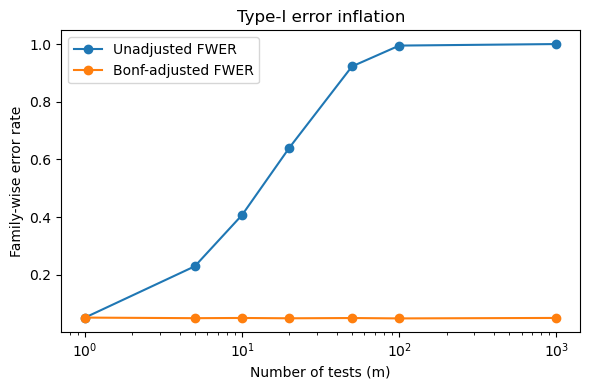

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)   # reproducible
alpha = 0.05                      # nominal significance level

def simulate_multiple_testing(m_list, reps=10_000):
    """
    Simulate chi-square (or any) p-values under H0 to illustrate
    Type-I inflation from multiple testing.

    Returns a DataFrame with FWER and mean false positives.
    """
    rows = []
    for m in m_list:
        # generate two-sided p-values from N(0,1) z-statistics
        z = rng.standard_normal(size=(reps, m))
        p = 2 * (1 - stats.norm.cdf(np.abs(z)))

        # unadjusted metrics
        fwer      = (p < alpha).any(axis=1).mean()
        mean_fp   = (p < alpha).sum(axis=1).mean()

        # Bonferroni adjustment
        thr_bonf  = alpha / m
        fwer_bonf = (p < thr_bonf).any(axis=1).mean()
        mean_fp_b = (p < thr_bonf).sum(axis=1).mean()

        rows.append({
            "m tests": m,
            "FWER (α=0.05)": fwer,
            "Avg FP": mean_fp,
            "FWER (Bonf α/m)": fwer_bonf,
            "Avg FP (Bonf)": mean_fp_b
        })
    return pd.DataFrame(rows)

# --- run simulation -------------------------------------------------
m_list = [1, 5, 10, 20, 50, 100, 1000]
df = simulate_multiple_testing(m_list)

print(df.to_string(index=False))

# --- quick visual ---------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(df["m tests"], df["FWER (α=0.05)"], 'o-', label='Unadjusted FWER')
plt.plot(df["m tests"], df["FWER (Bonf α/m)"], 'o-', label='Bonf-adjusted FWER')
plt.xscale('log'); plt.xlabel("Number of tests (m)")
plt.ylabel("Family-wise error rate"); plt.legend(); plt.title("Type-I error inflation")
plt.tight_layout(); plt.show()


#### Other Methods for Multiple Testing


* Holm–Bonferroni step-down procedure  
  Sequentially compares the ordered p-values to increasingly lenient thresholds $\alpha/(m-i+1)$ (with $i$ the rank of the p-value).  
  *Controls the family-wise error rate (FWER)* and is always at least as powerful as plain Bonferroni.   
  Variant: Hochberg step-up procedure, ...
   
* Benjamini–Hochberg (BH) procedure
  Orders p-values and finds the largest index $k$ with $p_{(k)} \le \tfrac{k}{m}\alpha$.  
  Controls the **false discovery rate (FDR)** instead of the FWER.    
  Yields much higher power for large-scale testing (e.g. genomics).   
  Variant: Benjamini–Yekutieli (BY) procedure, Storey’s $q$-value method, ...

* Westfall–Young permutation / bootstrap resampling    
  Generates the joint null distribution of the test statistics via resampling, then adjusts $p$-values.    
  Controls FWER and can be much less conservative than Bonferroni when test statistics are correlated.   

> Bottom-line: These methods trade off *strictness* (FWER control) against *power* (the ability to detect real effects).  The best choice depends on the study’s tolerance for false positives, the number of tests, and the dependence structure among them.




**Remark** Multiple testing has a new name when discussing confidence intervals: simultaneous confidence intervals, [confidence bands](https://en.wikipedia.org/wiki/Confidence_and_prediction_bands), or confidence regions. They all refer to a set of estimates that cover the true parameters with probability no smaller than the chosen confidence level. Here the parameters can be a finite or infinite set of parameters.  
